In [1]:
import pyodbc
import pandas as pd
import numpy as np
from datetime import  date, datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
%matplotlib inline
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.regularizers import l2
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

plt.rcParams['figure.figsize' ] = (16, 9)
plt.style.use('fast')


In [ ]:
sql_server="""
DRIVER={ODBC Driver 17 for SQL Server};
SERVER=US3RN4M3;
DATABASE=AdventureWorksDW2022;
Trusted_connection=yes;
"""

In [3]:
query="""
            SELECT
                CAST(f.OrderDate AS DATE) AS [sales_date],
                CAST(SUM(f.SalesAmount) AS INT) AS TotalVentas
            FROM
                FactInternetSales AS f
            WHERE 
                F.OrderDate > '2010-12-31' AND f.OrderDate < '2012-01-01'
            GROUP BY
                CAST(f.OrderDate AS DATE)
            ORDER BY
                CAST(f.OrderDate AS DATE) ASC;
"""

In [4]:
query2="""
            SELECT
                CAST(f.OrderDate AS DATE) AS [sales_date],
                CAST(SUM(f.SalesAmount) AS INT) AS TotalVentas
            FROM
                FactInternetSales AS f
            WHERE 
                F.OrderDate > '2010-12-31' AND f.OrderDate < '2014-01-01'
            GROUP BY
                CAST(f.OrderDate AS DATE)
            ORDER BY
                CAST(f.OrderDate AS DATE) ASC;
"""

In [5]:
PASOS = 31

In [6]:
#Opcion 1: Permitir que pueda ser modificada la sentencia, y mantener el try para evitar de que
# el programa se rompa
def get_sqlconnection(config_sqlServer):
    status = "inicializando...."
    try: 
        connection = pyodbc.connect(sql_server)
        status = "Conexion establecida satisfactoriamente"
    except Exception as e:
        status = "Error al establecer la conexión:"+e
    print(status)
    return connection

In [7]:
def set_index_datetime(data):
        if str(type(data) == "<class 'pandas.core.frame.DataFrame'>"):
            # data.sort_values('fecha', inplace=True)
            for column in data.columns: 
                try: 
                    pd.to_datetime(data[column])
                    data.set_index(column,inplace=True)
                    return data
                except Exception as e:  
                    pass
        else: 
            return 0

In [8]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
def create_x_y_train(data):
    values = data.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values= values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    values = reframed.values
    n_train_periods = int(len(data)) - (30+PASOS)
    print('Los periodos son: ',n_train_periods)
    train = values[:n_train_periods, :]
    test = values[n_train_periods:, :]
    x_train, y_train = train[:, :- 1], train[:, -1]
    x_val, y_val = test[:, :- 1], test[:, -1]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
    return x_train, y_train, x_val, y_val, scaler, values

In [10]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Dropout(0.3)) 
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer=RMSprop(learning_rate=0.001),metrics=['mse'])
    model.summary()
    return model

In [11]:
def entrenar_modelo(x_train, y_train, x_val, y_val, scaler, values, data, model):
    EPOCHS = 100
    # early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_val, y_val), batch_size=PASOS)
    results=model.predict(x_val)

    #Validaciones #1
    plt.scatter(range(len(y_val)),y_val,c='g', label='Valores Reales')
    plt.scatter(range(len(results)),results,c='r', label='Valores Predecidos')
    plt.xlabel('Índice')
    plt.ylabel('Valores(escalados)')
    plt.title('Grafico de dispersión entre Valores reales vs Predecidos ')
    plt.legend()
    plt.figtext(0.01,0.01,"Realizado el: "+datetime.now().strftime('%H:%M:%S %d-%m-%Y'),fontsize=10,color="gray")
    plt.figtext(0.60,0.01,"Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
    plt.show()

    #Validaciones #2 
    plt.plot(history.history['loss'],label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'],label='Pérdida de Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Grafico de Pérdidas de Entrenamiento y validación, según el # de Épocas')
    plt.legend()
    plt.figtext(0.01,0.01,"Realizado el: "+datetime.now().strftime('%H:%M:%S %d-%m-%Y'),fontsize=10,color="gray")
    plt.figtext(0.60,0.01,"Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
    plt.show()

    #Validación #3
    plt.title('Grafico de MSE de acuerdo al # de Épocas')
    plt.plot(history.history['mse'],label='MSE de Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()
    plt.figtext(0.01,0.01,"Realizado el: "+datetime.now().strftime('%H:%M:%S %d-%m-%Y'),fontsize=10,color="gray")
    plt.figtext(0.60,0.01,"Gestión de Innovación en Tecnología Informática S.C.P. | Grupo Consultores®", fontsize=10, color="gray")
    plt.show()

    #Preparamos la data a guardar en metadata
    datetim_e = datetime.now().strftime('%H:%M:%S %d-%m-%Y')
    optimizer_model = model.optimizer.get_config()

    #metadata
    metadata = [
            {
                "TOTAL_DE_DATOS": str(data.size),
                "EPOCH": len(history.history['loss']),
                "FECHA_ENTRENAMIENTO": datetim_e,
                "FECHA_MODIFICACION": datetim_e
            },
            optimizer_model
        ]
    print(metadata)


    ultimosDias = data[data.index[int(len(data)*0.70)]:]
    values = ultimosDias.values
    values = values.astype('float32' )
    values = values.reshape(-1, 1)
    scaled = values
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
    values = ultimosDias.values
    values = values.astype('float32' )
    values = values.reshape(-1, 1)
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[12]], axis=1, inplace=True)
    values = reframed.values
    x_test = values[len(values)-1:, :]
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
    return model, x_test

In [12]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

In [13]:
def eliminar_anomalias(dtaframe):
    dataFrame_anomalias = dtaframe.copy()
    modeloIsolation = IsolationForest(contamination=0.05)
    modeloIsolation.fit(dataFrame_anomalias)
    anomalias = modeloIsolation.predict(dataFrame_anomalias)
    dtaframe['anomalias' ] = anomalias
    dataFrameSinAnomalias = dtaframe[dtaframe['anomalias' ] != -1]
    dataFrameSinAnomalias = dataFrameSinAnomalias.drop('anomalias', axis=1)
    return dataFrameSinAnomalias

In [14]:
#Reconstruir el modelo
def reconstrured_modelFunc(model_path):
    model = load_model(model_path)
    model.summary()
    return model

Conexion establecida satisfactoriamente


C:\Users\JoCel\AppData\Local\Temp\ipykernel_8760\125673235.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  prepData = pd.read_sql_query(query,cursor)
C:\Users\JoCel\AppData\Local\Temp\ipykernel_8760\125673235.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  historyData = pd.read_sql_query(query2, cursor)


Days_format_detected
Los periodos son:  282
(282, 1, 31) (282,) (30, 1, 31) (30,)
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.3265 - mse: 0.1773 - val_loss: 0.3893 - val_mse: 0.2679
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3484 - mse: 0.1897 - val_loss: 0.3867 - val_mse: 0.2644
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3620 - mse: 0.2076 - val_loss: 0.3937 - val_mse: 0.2685
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3725 - mse: 0.2264 - val_loss: 0.3921 - val_mse: 0.2671
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3409 - mse: 0.1934 - val_loss: 0.3986 - val_mse: 0.2733
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3775 - mse: 0.2297 - val_loss: 0.4008 - val_mse: 0.2739
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3512 - mse: 0.2007 - val_loss: 0.3984 - val_mse: 0.2718
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3382 - mse: 0.1884 - val_loss:

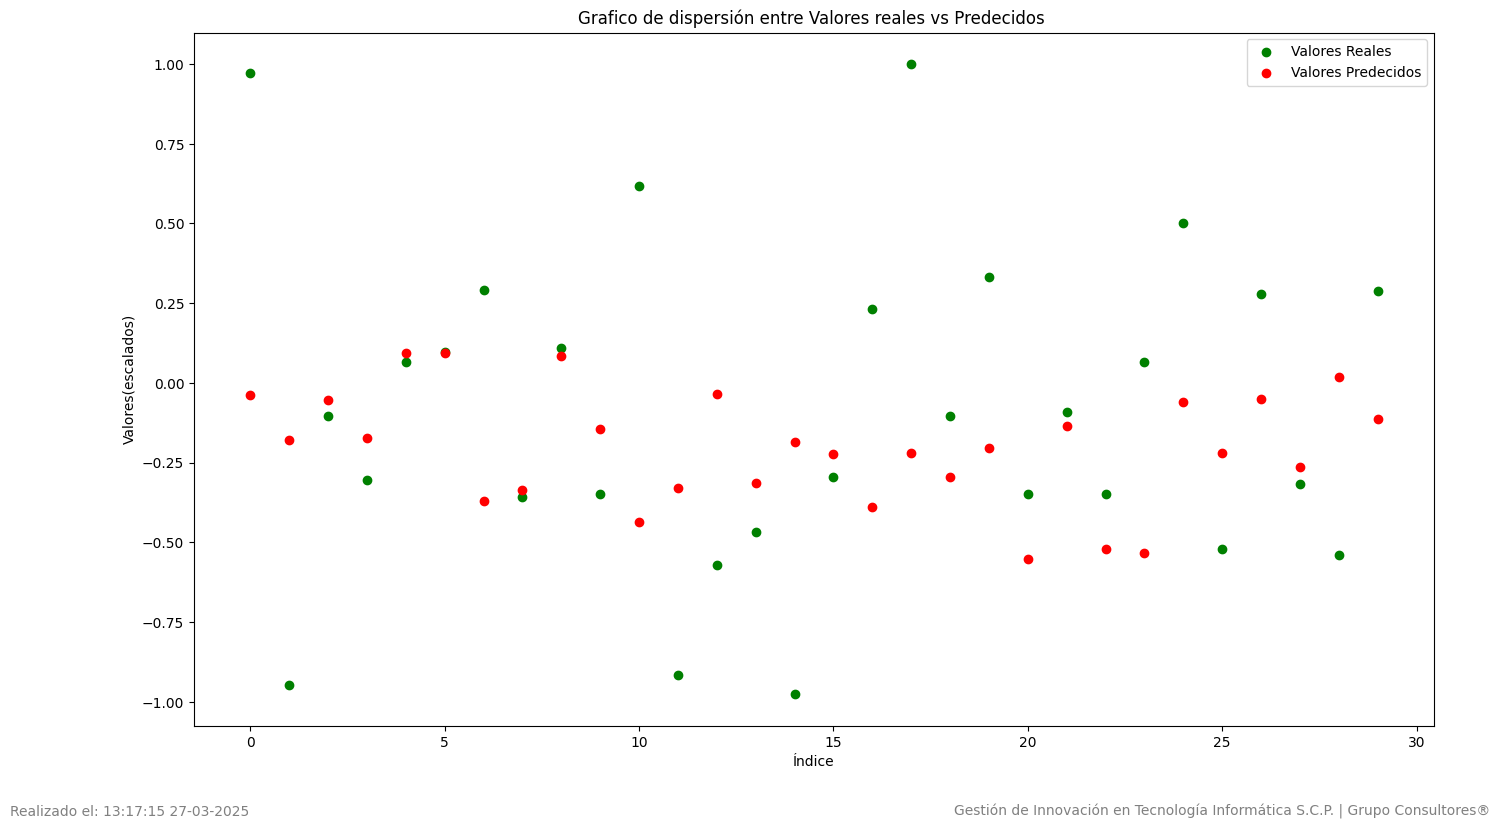

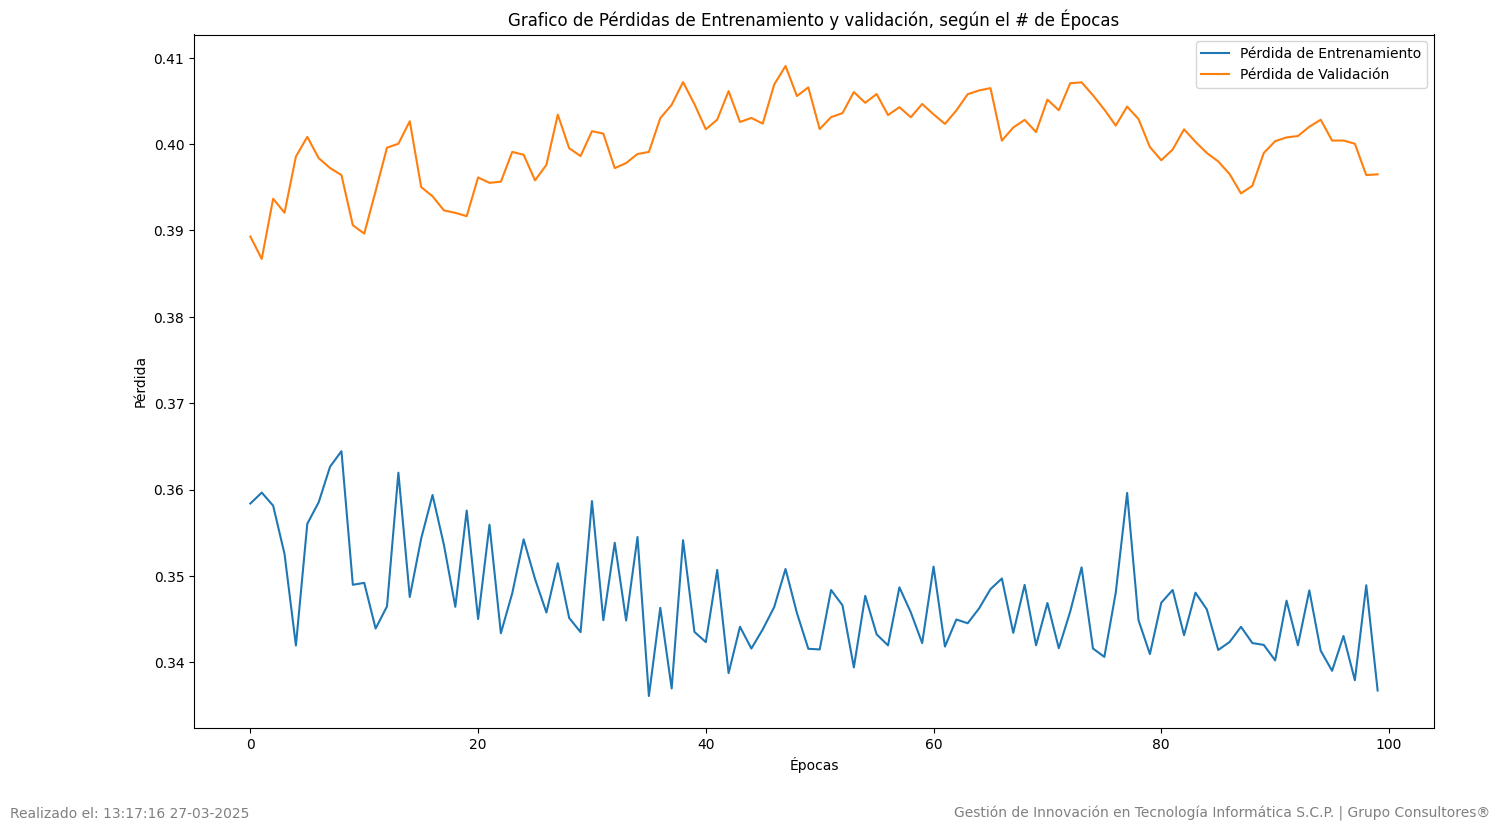

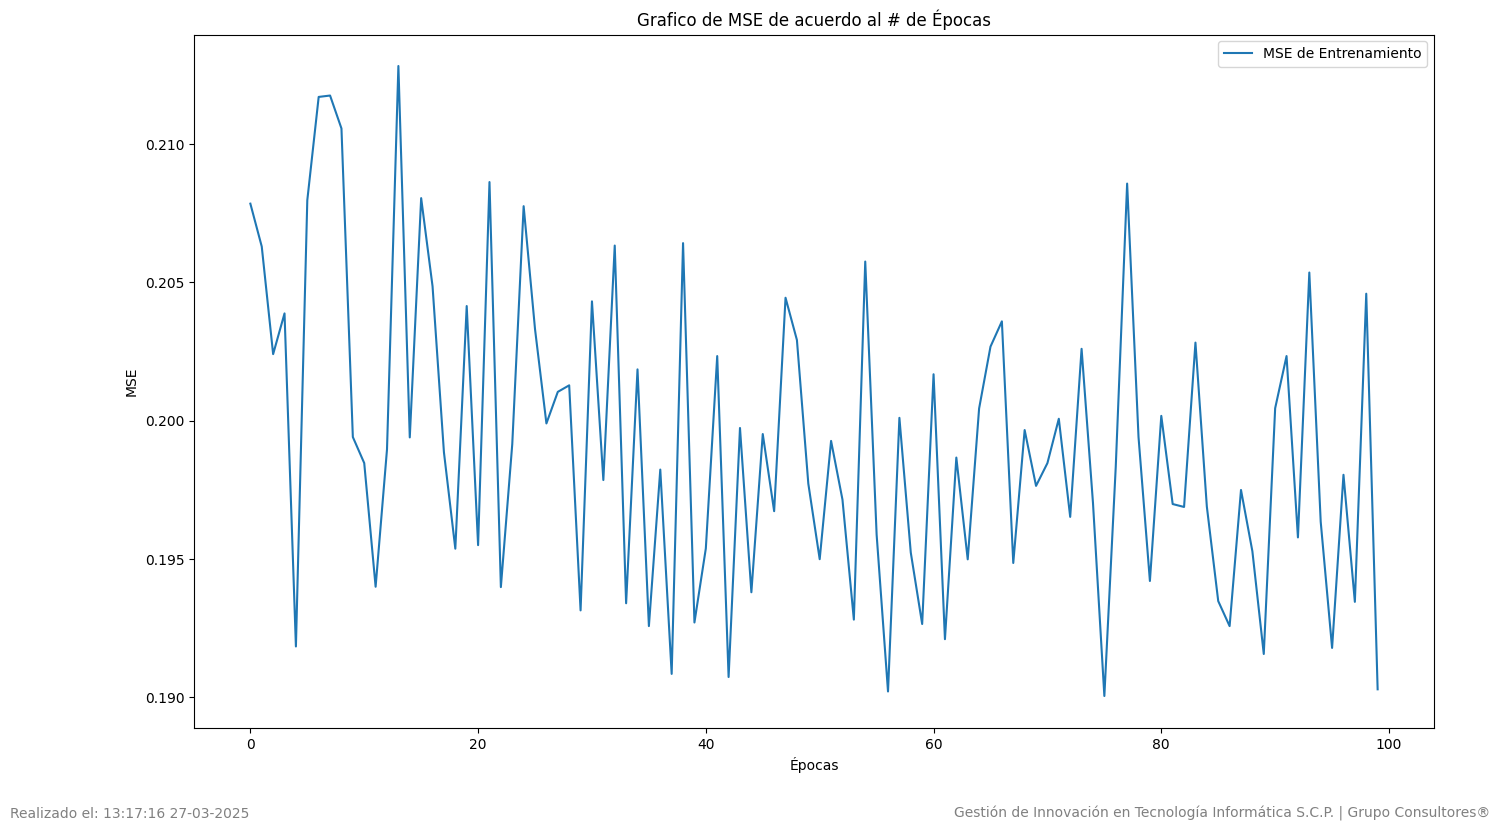

[{'TOTAL_DE_DATOS': '343', 'EPOCH': 100, 'FECHA_ENTRENAMIENTO': '13:17:16 27-03-2025', 'FECHA_MODIFICACION': '13:17:16 27-03-2025'}, {'name': 'rmsprop', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'rho': 0.9, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}]
[[[-0.97017705 -0.56886363  0.9716232  -0.97017705 -0.11856842
   -0.3219062   0.05488622  0.08627546  0.2812388  -0.37474394
    0.09699965 -0.36401975 -0.9387877  -0.590312   -0.48463666
   -0.99999994 -0.31118202  0.22340047  1.         -0.11856842
    0.32335222 -0.36401975 -0.10633802 -0.36401975  0.05338001
    0.49680686 -0.53898054  0.2690084  -0.3326304  -0.55771774
    0.279853  ]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


C:\Users\JoCel\AppData\Local\Temp\ipykernel_8760\3877792702.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_test[0][0][x_test.shape[2]-1]=nuevoValor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

In [15]:
with get_sqlconnection(sql_server) as cursor:
    #Get Data from source
    prepData = pd.read_sql_query(query,cursor)
    historyData = pd.read_sql_query(query2, cursor)

    #Convert data to datetime
    prepData = set_index_datetime(prepData)
    historyData = set_index_datetime(historyData)
    
    #Switch the format on days or months
    try: 
        #Si se trata de meses
        first_day = datetime.strptime(prepData.index.min(),'%Y-%m') + relativedelta(months=1)
        last_day = datetime.strptime(prepData.index.max(), '%Y-%m' ) + relativedelta(months=1)
        future_days = [last_day + relativedelta(months=i) for i in range(PASOS)]
        for i in range(len(future_days)):
            future_days[i] = str(future_days[i])[:7]
        print("Month_format_detected")
    except Exception as e: 
        #si se trata de dias
        print("Days_format_detected")
        first_day = prepData.index.min() + timedelta(days=1)
        last_day = prepData.index.max() + timedelta(days=1)
        future_days = [last_day + timedelta(days=i) for i in range(PASOS)]
        for i in range(len(future_days)):
            future_days[i] = str(future_days[i])[:10]
    #END TRY

    future_data = pd.DataFrame(future_days, columns=['fecha'])

    #Get the model !!Requires the models path!!!
    reconstruredModel = load_model('C:\GitHub\pronostico\pronostico\models\s2025-03-14\model-training2025-03-14_12-57-07\model_training-2025-03-14_12-57-07.keras')

    #Compile the model 
    model = reconstruredModel

    #This part should be remplaced to the values at DB
    model.compile(loss='mean_absolute_error',optimizer=RMSprop(learning_rate=0.001),metrics=['mse'])
    
    #Make to train the model
    data = []
    for column in prepData.columns:
        data = prepData.filter([column])
        data.set_index(prepData.index, inplace=True)
        data = eliminar_anomalias(data)
        x_train, y_train, x_val, y_val, scaler, values = create_x_y_train(data)
        model, x_test = entrenar_modelo(x_train, y_train, x_val, y_val, scaler, values, data, model)
        print(x_test)
        results = []
        for i in range(PASOS):
            parcial = model.predict(x_test)
            results.append(parcial[0])
            x_test = agregarNuevoValor(x_test, parcial[0])
        adimen = [x for x in results]
        inverted = scaler.inverse_transform(adimen)
        # y_pred = pd.DataFrame(inverted.astype(int))
        future_data[column]= inverted.astype(int)
    future_data = set_index_datetime(future_data)

    #Function to save the model

    #Funcion to makes testing of the model



    